In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re

⭐️ 최종 모델 ⭐️ 
**0.7628**
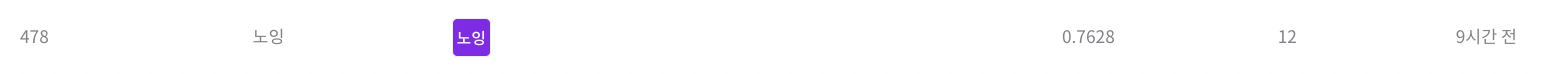

# 데이터 로드

In [4]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# 결측치 처리

## Age
- Pclass별 평균 나이로 대체
- 단순 평균 나이로 대체하는 것보다 정확도 향상

In [5]:
def fill_age(data):
    null_idx = data[data['Age'].isnull()].index
    for idx in null_idx:
        pclass = data.loc[idx, 'Pclass']
        if pclass == 1:
            age = 38
        elif pclass == 2:
            age = 29
        else:
            age = 24
        data.loc[idx, 'Age'] = age
    return data

In [6]:
train = fill_age(train)
test = fill_age(test)

## Embarked
- 결측치 2개 → 삭제

In [7]:
train.dropna(subset='Embarked', axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

## Fare
- 결측치 1개 → 해당되는 Pclass의 평균 요금으로 대체

In [8]:
test.fillna(round(train[train['Pclass'] == 3]['Fare'].mean(), 5), inplace=True)

# Feature Engineering

## Cabin_first
- Cabin의 첫번째 문자만 추출

In [9]:
train['Cabin_first'] = train['Cabin'].str[0]
test['Cabin_first'] = test['Cabin'].str[0]

In [10]:
def fill_cabin(index, data):
    pclass = data.loc[index, 'Pclass']
    fare = data.loc[index, 'Fare']
    if pclass == 1:
        if fare >= 114.505764:
            cabin = 'B'
        elif fare >= 100.151341:
            cabin = 'C'
        elif fare >= 63.324286:
            cabin = 'D'
        elif fare >= 55.740168:
            cabin = 'E'
        else:
            cabin = 'A'
    elif pclass == 2:
        cabin = 'F'
    else:
        cabin = 'G'
    data.loc[index, 'Cabin_first'] = cabin
    return data

In [11]:
null_index = list(train[train['Cabin_first'].isnull()].index)
for idx in null_index:
    train = fill_cabin(idx, train)

null_index = list(test[test['Cabin_first'].isnull()].index)
for idx in null_index:
    test = fill_cabin(idx, test)

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_first
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,G
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,G
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,G


## title
- Name 중 호칭(ex. Mr., Miss)만 추출
- title 변수 사용 시 정확도 10% 이상 향상

In [13]:
train['title'] = train['Name'].str.split(',').apply(lambda x: x[1]).str.split('.').apply(lambda x: x[0].strip())
test['title'] = test['Name'].str.split(',').apply(lambda x: x[1]).str.split('.').apply(lambda x: x[0].strip())

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_first,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,G,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,G,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,G,Mr


In [15]:
train['title'] = train['title'].replace(['Capt', 'Col', 'the Countess', 'Dr', 'Jonkheer', 'Major', 'Rev', 'Sir'], 'Others')
train['title'] = train['title'].replace(['Mlle', 'Ms'], 'Miss')
train['title'] = train['title'].replace('Don', 'Mr')
train['title'] = train['title'].replace(['Mme', 'Lady', 'Dona'], 'Mrs')

test['title'] = test['title'].replace(['Capt', 'Col', 'the Countess', 'Dr', 'Jonkheer', 'Major', 'Rev', 'Sir'], 'Others')
test['title'] = test['title'].replace(['Mlle', 'Ms'], 'Miss')
test['title'] = test['title'].replace('Don', 'Mr')
test['title'] = test['title'].replace(['Mme', 'Lady', 'Dona'], 'Mrs')

In [16]:
train['title'].value_counts()

Mr        518
Miss      184
Mrs       126
Master     40
Others     21
Name: title, dtype: int64

In [17]:
test['title'].value_counts()

Mr        240
Miss       79
Mrs        73
Master     21
Others      5
Name: title, dtype: int64

## Fare / Age
- 나이는 적을수록, 요금은 클수록 생존 확률이 높다 → **Fare / Age**
- Fare, Age 2개 변수를 사용하는 것보다 정확도 향상

In [18]:
# train['Fare/Age'] = train['Fare'] / train['Age']
# test['Fare/Age'] = test['Fare'] / test['Age']

## FareGroup / AgeGroup
- Age, Fare을 범주화한 경우 정확도 향상
- Age, Fare을 일정 구간 기준으로 범주화한 후, 범주화된 값으로 계산
- Fare / Age를 변수로 사용한 경우보다 정확도 향상

### AgeGroup

In [19]:
ranges=[0,16,26,36,62,100]
labels=[1,2,3,4,5]
train["AgeGroup"]=pd.cut(train['Age'],ranges,right=False,labels=labels)
test["AgeGroup"]=pd.cut(test['Age'],ranges,right=False,labels=labels)
train['AgeGroup'] = train['AgeGroup'].astype('int')
test['AgeGroup'] = train['AgeGroup'].astype('int')

In [20]:
train.groupby('AgeGroup')['Survived'].mean()

AgeGroup
1    0.590361
2    0.307910
3    0.420290
4    0.400881
5    0.222222
Name: Survived, dtype: float64

### FareGroup

In [21]:
ranges=[0,17,30,100,1000]
labels=[1,2,3,4]
train["FareGroup"]=pd.cut(train['Fare'],ranges,right=False,labels=labels)
test["FareGroup"]=pd.cut(train['Fare'],ranges,right=False,labels=labels)
train['FareGroup'] = train['FareGroup'].astype('int')
test['FareGroup'] = test['FareGroup'].astype('int')

In [22]:
train.groupby('FareGroup')['Survived'].mean()

FareGroup
1    0.266129
2    0.445161
3    0.540541
4    0.735849
Name: Survived, dtype: float64

### FareGroup / AgeGroup

In [23]:
train['FareGroup/AgeGroup'] = train['FareGroup'] / train['AgeGroup']
test['FareGroup/AgeGroup'] = test['FareGroup'] / test['AgeGroup']

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_first,title,AgeGroup,FareGroup,FareGroup/AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,G,Mr,2,1,0.500000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs,4,3,0.750000
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,G,Miss,3,1,0.333333
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs,3,3,1.000000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,G,Mr,3,1,0.333333


## Familysize
- SibSp, Parch 합계
- SibSp, Parch를 각각 학습한 것보다 Familysize로 학습하여 성능 개선

In [25]:
train['Familysize']=train['SibSp'] + train['Parch']
test['Familysize']= test['SibSp'] + test['Parch']

In [26]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_first,title,AgeGroup,FareGroup,FareGroup/AgeGroup,Familysize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,G,Mr,2,1,0.500000,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs,4,3,0.750000,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,G,Miss,3,1,0.333333,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs,3,3,1.000000,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,G,Mr,3,1,0.333333,0


## ticket_prefix

In [27]:
def get_ticket_prefix(ticket):
    split = ticket.split(' ')
    if len(split) == 1:
        return 'NONE'
    else:
        return split[0]

In [28]:
train['ticket_prefix'] = train['Ticket'].apply(lambda x: get_ticket_prefix(x))
test['ticket_prefix'] = test['Ticket'].apply(lambda x: get_ticket_prefix(x))

In [29]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_first,title,AgeGroup,FareGroup,FareGroup/AgeGroup,Familysize,ticket_prefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,G,Mr,2,1,0.500000,1,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs,4,3,0.750000,1,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,G,Miss,3,1,0.333333,0,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs,3,3,1.000000,1,NONE
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,G,Mr,3,1,0.333333,0,NONE


## ticket_PC
- ticket_prefix가 'PC'인 경우 생존률 높음 (검색 결과 Private Class로 추측)
- ticket_PC 추가 시 정확도 향상

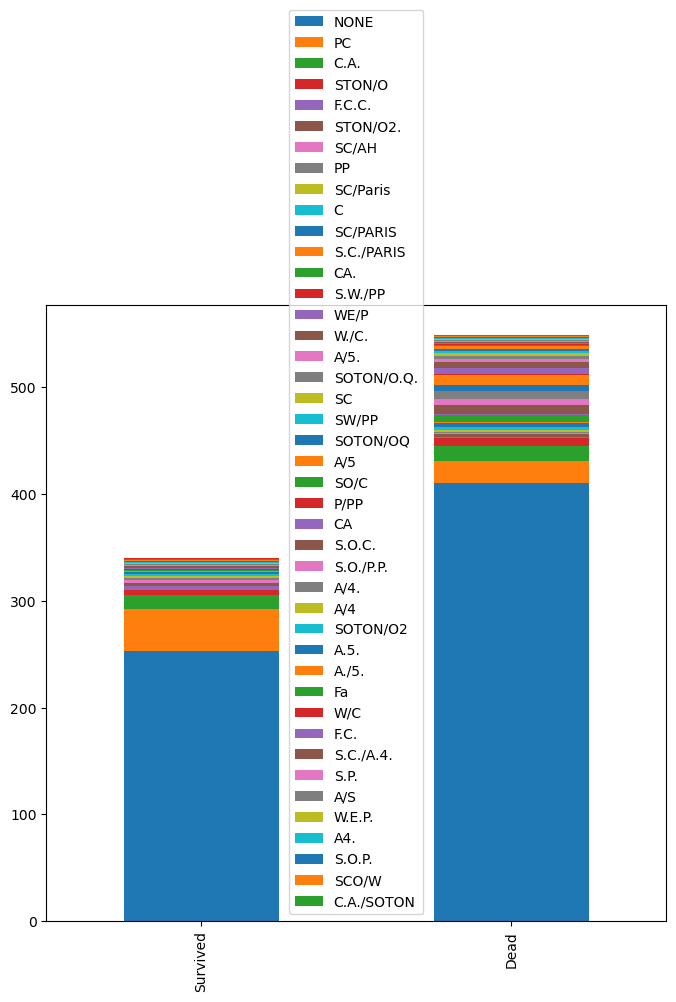

In [30]:
def bar_chart(feature):
    survived = train[train['Survived'] == 1][feature].value_counts()
    dead = train[train['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', stacked=True, figsize=(8, 8))

bar_chart('ticket_prefix')

In [32]:
train['ticket_PC'] = train['ticket_prefix'].apply(lambda x: 1 if x == 'PC' else 0)
test['ticket_PC'] = test['ticket_prefix'].apply(lambda x: 1 if x == 'PC' else 0)

In [33]:
train.groupby('ticket_PC')['Survived'].mean()

ticket_PC
0    0.363088
1    0.650000
Name: Survived, dtype: float64

## Embarked_C
- Embarked가 'C'인 경우 생존률 높음
- Embarked의 모든 값을 one hot encoding해서 학습을 한 결과보다 정확도 향상
- chatGPT 도와줘! → 랜덤으로 인한 결과? → **학습에 포함시키지 않은 경우 성능 향상** → **유의미한 변수가 아님을 확인**
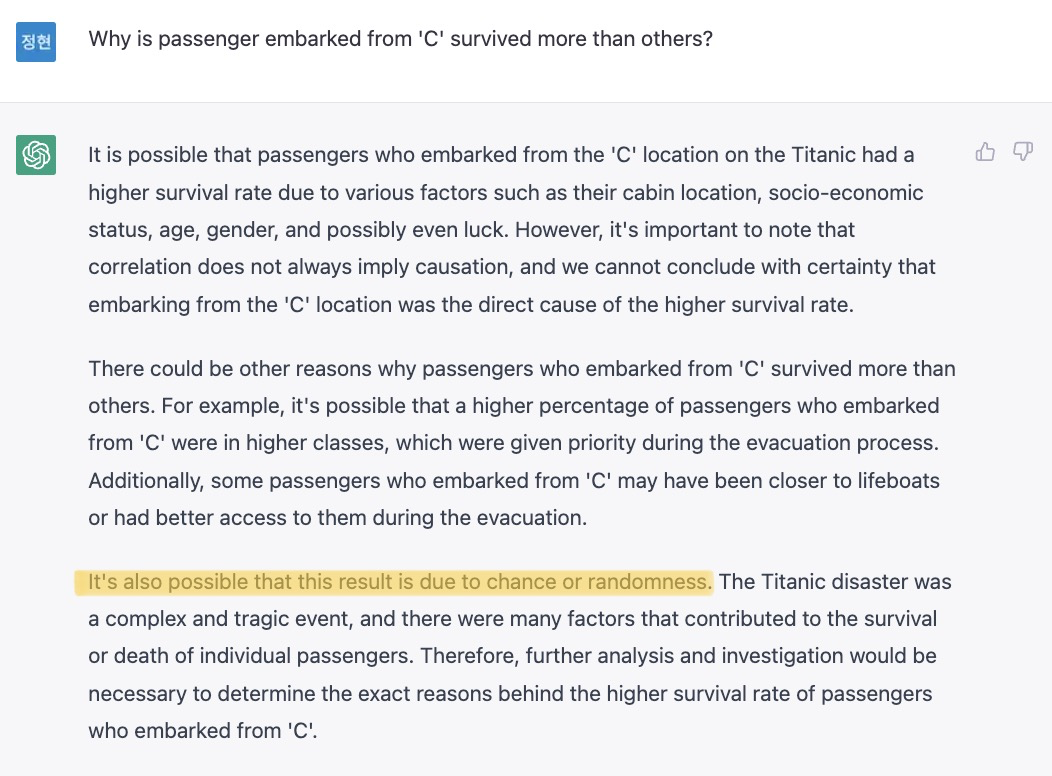

In [ ]:
# train['Embarked_C'] = train['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
# test['Embarked_C'] = test['Embarked'].apply(lambda x: 1 if x == 'C' else 0)

# 학습 데이터
- 새로운 feature을 만들거나, 연관 있는 feature을 제거하면서 모델 성능 비교
- 최종 학습 변수
    - Pclass
    - FamilySize
    - title
    - FareGroup/AgeGroup
    - ticket_PC

In [34]:
train_df = train[['Survived', 'Pclass', 'Familysize',
                  'title', 'FareGroup/AgeGroup', 'ticket_PC']]
test_df = test[['Pclass', 'Familysize',
                'title', 'FareGroup/AgeGroup', 'ticket_PC']]

<AxesSubplot:>

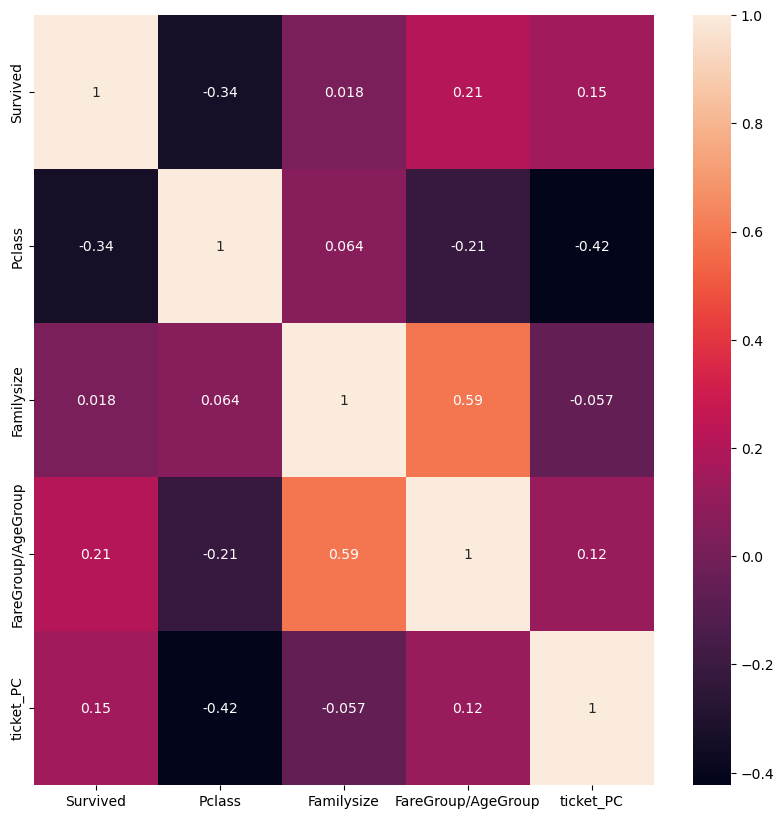

In [35]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=train_df.corr(), annot=True)

# Encoding

In [37]:
def label_encoding(feature, train_df, test_df):
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    train_df[feature] = le.fit_transform(train_df[feature])
    test_df[feature] = le.transform(test_df[feature])
    return train_df, test_df

def one_hot_encoding(feature, train_df, test_df):
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    encoded_train = ohe.fit_transform(train_df[feature].values.reshape(-1, 1))
    train_df = pd.concat([train_df,
                          pd.DataFrame(encoded_train, columns=[feature + '_' + col for col in ohe.categories_[0]])],
                          axis=1)
    encoded_test = ohe.transform(test[feature].values.reshape(-1, 1))
    test_df = pd.concat([test_df,
                         pd.DataFrame(encoded_test, columns=[feature + '_' + col for col in ohe.categories_[0]])],
                         axis=1)
    return train_df, test_df

## Sex
- male : 0
- female : 1

In [38]:
# train_df['Sex'] = train_df['Sex'].map({'male':0, 'female':1})
# test_df['Sex'] = test_df['Sex'].map({'male':0, 'female':1})

## Embarked
- 원핫인코딩

In [39]:
# train_df, test_df = one_hot_encoding('Embarked', train_df, test_df)
# train_df.drop(columns='Embarked', axis=1, inplace=True)
# test_df.drop(columns='Embarked', axis=1, inplace=True)

## title
- 원핫인코딩

In [40]:
train_df, test_df = one_hot_encoding('title', train_df, test_df)
train_df.drop('title', axis=1, inplace=True)
test_df.drop('title', axis=1, inplace=True)

## Cabin_first
- 레이블인코딩 (순서 상관 O)

In [ ]:
# train_df, test_df = label_encoding('Cabin_first', train_df, test_df)

# 스케일링
- 최종 모델에서는 스케일링을 진행하지 않음
- 스케일링을 사용한 경우, StandardScaler을 사용했을 때 정확도 미미하게 향상

In [ ]:
# 4. Scaling
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler

# def scaling(feature, train_df, test_df):
#     scaler = StandardScaler()
#     train_scaled = scaler.fit_transform(train_df[feature].values.reshape(-1, 1))
#     test_scaled = scaler.transform(test_df[feature].values.reshape(-1, 1))
#     train_df[feature] = train_scaled
#     test_df[feature] = test_scaled
#     return train_df, test_df

# train_df, test_df = scaling('Fare/Age', train_df, test_df)

# 모델링
- 동일하게 전처리한 상태에서 모델 파라미터를 변경하며 성능 비교  
    https://www.notion.so/cc420e7c500f4f86939201cc7fa36b95?pvs=4
- 가장 성능이 좋았던 파라미터로 고정 후, feature 변경 / 전처리 방법 변경을 통해 성능 비교

In [41]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns='Survived', axis=1)
y = train_df['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=10)

## LogisticRegression

In [42]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
print('LogisticRegression')
print('train score : {:.3f}'.format(model_lr.score(X_train, y_train)))
print('test socre : {:.3f}'.format(model_lr.score(X_valid, y_valid)))

LogisticRegression
train score : 0.824
test socre : 0.860


## DecisionTree

In [43]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(criterion='entropy',
                                  min_samples_split=20,
                                  max_depth=10,
                                  random_state=10)
model_dt.fit(X_train, y_train)
print('DecisionTree')
print('train score : {:.3f}'.format(model_dt.score(X_train, y_train)))
print('test socre : {:.3f}'.format(model_dt.score(X_valid, y_valid)))

DecisionTree
train score : 0.841
test socre : 0.860


## RandomForest

In [44]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=500, 
                                  min_samples_split=20,
                                  max_depth=10,
                                  random_state=10)
model_rf.fit(X_train, y_train)
print('RandomForest')
print('train score : {:.3f}'.format(model_rf.score(X_train, y_train)))
print('test socre : {:.3f}'.format(model_rf.score(X_valid, y_valid)))

RandomForest
train score : 0.840
test socre : 0.865


## XGBoost

In [45]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(random_state=10)
model_xgb.fit(X_train, y_train)
print('XGBoost')
print('train score : {:.3f}'.format(model_xgb.score(X_train, y_train)))
print('test socre : {:.3f}'.format(model_xgb.score(X_valid, y_valid)))

XGBoost
train score : 0.855
test socre : 0.871


## LightGBM

In [46]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=10)
evals = [(X_train, y_train), (X_valid, y_valid)]
lgbm.fit(X_train, y_train, early_stopping_rounds=400, eval_metric='accuracy', eval_set=evals)
print('LightGBM')
print('train score : {:.3f}'.format(lgbm.score(X_train, y_train)))
print('test socre : {:.3f}'.format(lgbm.score(X_valid, y_valid)))

[1]	training's binary_logloss: 0.646587	valid_1's binary_logloss: 0.628381
[2]	training's binary_logloss: 0.628069	valid_1's binary_logloss: 0.606607
[3]	training's binary_logloss: 0.610225	valid_1's binary_logloss: 0.586943
[4]	training's binary_logloss: 0.594104	valid_1's binary_logloss: 0.569136
[5]	training's binary_logloss: 0.579461	valid_1's binary_logloss: 0.552927
[6]	training's binary_logloss: 0.566119	valid_1's binary_logloss: 0.537631
[7]	training's binary_logloss: 0.553961	valid_1's binary_logloss: 0.523626
[8]	training's binary_logloss: 0.542827	valid_1's binary_logloss: 0.511185
[9]	training's binary_logloss: 0.53251	valid_1's binary_logloss: 0.499547
[10]	training's binary_logloss: 0.523128	valid_1's binary_logloss: 0.489013
[11]	training's binary_logloss: 0.514393	valid_1's binary_logloss: 0.479289
[12]	training's binary_logloss: 0.506441	valid_1's binary_logloss: 0.470419
[13]	training's binary_logloss: 0.499011	valid_1's binary_logloss: 0.461953
[14]	training's binary

# 교차검증
- 정확도 감소
- 인덱스 또는 학습 데이터 수가 너무 적기 때문?

In [47]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [48]:
kfold = KFold(n_splits =5)
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=10)
cv_accuracy = []
n_iter = 0
for train_index, test_index in kfold.split(X):
    train_x, X_test = X.loc[train_index], X.loc[test_index]
    train_y, y_test = y.loc[train_index], y.loc[test_index]
    lgbm.fit(train_x, train_y)
    pred = lgbm.predict(X_test)
    n_iter+=1
    accuracy = np.round(accuracy_score(y_test, pred),4)
    train_size = train_x.shape[0]
    test_size = X_test.shape[0]
    print('\n#{0} 교차검증 정확도 : {1}, 학습 데이터 크기 : {2} , 검증 데이터 크기: {3}'.format(n_iter, accuracy, train_size, test_size))
    cv_accuracy.append(accuracy)
print('\n## 평균 검증 정확도 :', np.mean(cv_accuracy))


#1 교차검증 정확도 : 0.8146, 학습 데이터 크기 : 711 , 검증 데이터 크기: 178

#2 교차검증 정확도 : 0.8034, 학습 데이터 크기 : 711 , 검증 데이터 크기: 178

#3 교차검증 정확도 : 0.8427, 학습 데이터 크기 : 711 , 검증 데이터 크기: 178

#4 교차검증 정확도 : 0.8146, 학습 데이터 크기 : 711 , 검증 데이터 크기: 178

#5 교차검증 정확도 : 0.8475, 학습 데이터 크기 : 712 , 검증 데이터 크기: 177

## 평균 검증 정확도 : 0.82456


# 제출

In [49]:
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=10)
lgbm.fit(X, y, eval_metric='accuracy')

LGBMClassifier(learning_rate=0.05, random_state=10)

In [50]:
y_pred = lgbm.predict(test_df)

In [51]:
sub_df = pd.read_csv('./submission.csv')
sub_df['Survived'] = y_pred
sub_df.to_csv('./submission_final.csv', index=False)

# 마무리

- **변수 생성**, **변수 선정**의 중요성
- **도메인 지식**의 중요성